# LSTM post-processing

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset

## Read input

In [2]:
import os
os.chdir('/mnt/guanabana/raid/home/slomp006')

# Train and vali should have been uploaded to server
# Reference data
traindf = pd.read_csv('Input/train20152018.csv')
validf = pd.read_csv('Input/vali20152018.csv')

# Predictions (upload RF predictions also to server)
LSTM_pred = pd.read_csv('Output/LSTM/LSTM_pred.csv')
RF_pred2015 = pd.read_csv("Output/RF/RFpredict2015.csv")
RF_pred2016 = pd.read_csv("Output/RF/RFpredict2016.csv")
RF_pred2017 = pd.read_csv("Output/RF/RFpredict2017.csv")
RF_pred2018 = pd.read_csv("Output/RF/RFpredict2018.csv")

# Remove NaN
LSTM_pred = LSTM_pred.dropna()
RF_pred2015 = RF_pred2015.dropna()
RF_pred2016 = RF_pred2016.dropna()
RF_pred2017 = RF_pred2017.dropna()
RF_pred2018 = RF_pred2018.dropna()

# Prediction don't have the same samples. Use similar IDs.
common_ids = set(RF_pred2015['sample_id']).intersection(RF_pred2016['sample_id'], RF_pred2017['sample_id'], RF_pred2018['sample_id'])

# Filter the DataFrames to only include rows with common sample_id values
RF_pred2015 = RF_pred2015[RF_pred2015['sample_id'].isin(common_ids)]
RF_pred2016 = RF_pred2016[RF_pred2016['sample_id'].isin(common_ids)]
RF_pred2017 = RF_pred2017[RF_pred2017['sample_id'].isin(common_ids)]
RF_pred2018 = RF_pred2018[RF_pred2018['sample_id'].isin(common_ids)]

# Add reference year column
RF_pred2015['reference_year'] = 2015
RF_pred2016['reference_year'] = 2016
RF_pred2017['reference_year'] = 2017
RF_pred2018['reference_year'] = 2018

# Create one big RF prediction data frame
RF_pred = pd.concat([RF_pred2015, RF_pred2016, RF_pred2017, RF_pred2018])
RF_pred = RF_pred.sort_values(['sample_id', 'reference_year'])

# Now also create validation separate for LSTM and RF
common_LSTM = set(LSTM_pred['sample_id']).intersection(validf['sample_id'])
common_RF = set(RF_pred['sample_id']).intersection(validf['sample_id'])

LSTM_vali = validf[validf['sample_id'].isin(common_LSTM)]
RF_vali = validf[validf['sample_id'].isin(common_RF)]

print(len(LSTM_pred), len(LSTM_vali))
print(len(RF_pred), len(RF_vali))

121956 121956
118680 118680


## Create tensors from input

In [3]:
# Classes are targets
targets = ['bare', 'crops',
       'grassland', 'shrub', 'tree', 'urban_built_up', 'water']

# Make synthetic data based on input variables
inputs = ['x', 'y', 'b1_median', 'b2_median', 'b3_median',
       'b4_median', 'b5_median', 'b6_median', 'b7_median', 'nbr_median',
       'ndmi_median', 'ndvi_median', 'nbr_iqr', 'ndmi_iqr', 'ndvi_iqr',
       'min', 'max', 'intercept', 'co', 'si', 'co2', 'si2', 'trend',
       'phase1', 'amplitude1', 'phase2', 'amplitude2']

# Also save IDs for later
IDs = ['sample_id', 'location_id', 'reference_year']

# Create lists
LSTM_pred_list = []
RF_pred_list = []

# Validation
LSTM_vali_list = []
RF_vali_list = []

# Training
train_list = []

for colname in targets: 
    # Get column of feature
    col_LSTM = LSTM_pred[colname]
    col_LSTM_vali = LSTM_vali[colname]
    col_RF = RF_pred[colname]
    col_RF_vali = RF_vali[colname]
    col_training = traindf[colname]

    # Create tensors with sequence lengths of 4
    LSTM_tensor = torch.tensor(col_LSTM.values).view(-1, 4, 1).to(dtype=torch.float32)
    LSTM_vali_tensor = torch.tensor(col_LSTM_vali.values).view(-1, 4, 1).to(dtype=torch.float32)
    RF_tensor = torch.tensor(col_RF.values).view(-1, 4, 1).to(dtype=torch.float32)
    RF_vali_tensor = torch.tensor(col_RF_vali.values).view(-1, 4, 1).to(dtype=torch.float32)
    training_tensor = torch.tensor(col_training.values).view(-1, 4, 1).to(dtype=torch.float32)

    # Append to lists
    LSTM_pred_list.append(LSTM_tensor)
    LSTM_vali_list.append(LSTM_vali_tensor)
    RF_pred_list.append(RF_tensor)
    RF_vali_list.append(RF_vali_tensor)
    train_list.append(training_tensor)
    
# We now each class as a separate tensor but we want them as one. So concatenate the tensors along the last dimension
tensor_LSTM = torch.cat(LSTM_pred_list, dim=-1)
tensor_LSTM_vali = torch.cat(LSTM_vali_list, dim=-1)
tensor_RF = torch.cat(RF_pred_list, dim=-1)
tensor_RF_vali = torch.cat(RF_vali_list, dim=-1)
tensor_training = torch.cat(train_list, dim=-1)

# Do the same for the input var for the synthetic data
input_list = []

# Also create inputs for LSTM and RF
LSTM_input_list = []
RF_input_list = []
for colname in inputs:
    col_var = traindf[colname]
    col_LSTM = LSTM_vali[colname]
    col_RF = RF_vali[colname]
    
    var_tensor = torch.tensor(col_var.values).view(-1, 4, 1).to(dtype=torch.float32)
    LSTM_tensor = torch.tensor(col_LSTM.values).view(-1, 4, 1).to(dtype=torch.float32)
    RF_tensor = torch.tensor(col_RF.values).view(-1, 4, 1).to(dtype=torch.float32)
    
    input_list.append(var_tensor)
    LSTM_input_list.append(LSTM_tensor)
    RF_input_list.append(RF_tensor)
    
tensor_inputs = torch.cat(input_list, dim=-1)
LSTM_inputs = torch.cat(LSTM_input_list, dim=-1)
RF_inputs = torch.cat(RF_input_list, dim=-1)

# From LSTM and RF inputs, create a LSTM and RF tensor that also contains input data
tensor_LSTM_inputs = torch.cat([LSTM_inputs, tensor_LSTM], dim=-1)
tensor_RF_inputs = torch.cat([RF_inputs, tensor_RF], dim=-1)

# And for IDs
LSTM_ID_list = []
RF_ID_list = []
for colname in IDs:
    ID_LSTM = LSTM_vali[colname]
    ID_RF = RF_vali[colname]
    ID_LSTM_tensor = torch.tensor(ID_LSTM.values).view(-1, 4, 1).to(dtype=torch.float32)
    ID_RF_tensor = torch.tensor(ID_RF.values).view(-1, 4, 1).to(dtype=torch.float32)
    LSTM_ID_list.append(ID_LSTM_tensor)
    RF_ID_list.append(ID_RF_tensor)
tensor_LSTM_IDs = torch.cat(LSTM_ID_list, dim=-1)
tensor_RF_IDs = torch.cat(RF_ID_list, dim=-1)

# Check for NaN tensors
tensor_inputs_old = tensor_inputs
tensor_training_old = tensor_training
tensor_LSTM_inputs_old = tensor_LSTM_inputs
tensor_RF_inputs_old = tensor_RF_inputs

# create an empty mask
mask = None

# Remove for each tensor that need to be similar
if torch.isnan(tensor_inputs).any():
    mask = torch.isnan(tensor_inputs).any(dim=1).any(dim=1)
    tensor_inputs = tensor_inputs[~mask]
    tensor_training = tensor_training[~mask]
if torch.isnan(tensor_training).any():
    mask = torch.isnan(tensor_training).any(dim=1).any(dim=1) 
    tensor_training = tensor_training[~mask]
    tensor_inputs = tensor_inputs[~mask]
if torch.isnan(tensor_LSTM_inputs).any():
    mask = torch.isnan(tensor_LSTM_inputs).any(dim=1).any(dim=1) 
    tensor_LSTM_inputs = tensor_LSTM_inputs[~mask]
    tensor_LSTM_vali = tensor_LSTM_vali[~mask]
    tensor_LSTM_IDs = tensor_LSTM_IDs[~mask]
if torch.isnan(tensor_RF_inputs).any():
    mask = torch.isnan(tensor_RF_inputs).any(dim=1).any(dim=1) 
    tensor_RF_inputs = tensor_RF_inputs[~mask]
    tensor_RF_vali = tensor_RF_vali[~mask]
    tensor_RF_IDs = tensor_RF_IDs[~mask]

# Check final tensors (including shape)
print("LSTM input variables contained nan values: ", torch.isnan(tensor_LSTM_inputs_old).any())
print("RF input variables contained nan values: ", torch.isnan(tensor_RF_inputs_old).any())
print("LSTM tensor has shape:", tensor_LSTM.shape, "LSTM with inputs has shape:", tensor_LSTM_inputs.shape)
print("--> LSTM vali has shape:", tensor_LSTM_vali.shape, "and respective ID has shape: ", tensor_LSTM_IDs.shape)
print("RF tensor has shape:", tensor_RF.shape, "RF with inputs has shape:", tensor_RF_inputs.shape)
print(" --> RF vali has shape:", tensor_RF_vali.shape, "and respective ID has shape: ", tensor_RF_IDs.shape, "\n")
print("Input columns for synthesized data contained nan values: ", torch.isnan(tensor_inputs_old).any())
print("Training contained nan values: ", torch.isnan(tensor_training_old).any())
print("Old shape of synth inputs tensor: ", tensor_inputs_old.shape, "New shape: ", tensor_inputs.shape)
print("Old shape of training tensor: ", tensor_training_old.shape, "New shape: ", tensor_training.shape)


LSTM input variables contained nan values:  tensor(False)
RF input variables contained nan values:  tensor(False)
LSTM tensor has shape: torch.Size([30489, 4, 7]) LSTM with inputs has shape: torch.Size([30489, 4, 34])
--> LSTM vali has shape: torch.Size([30489, 4, 7]) and respective ID has shape:  torch.Size([30489, 4, 3])
RF tensor has shape: torch.Size([29670, 4, 7]) RF with inputs has shape: torch.Size([29670, 4, 34])
 --> RF vali has shape: torch.Size([29670, 4, 7]) and respective ID has shape:  torch.Size([29670, 4, 3]) 

Input columns for synthesized data contained nan values:  tensor(False)
Training contained nan values:  tensor(False)
Old shape of synth inputs tensor:  torch.Size([33405, 4, 27]) New shape:  torch.Size([33405, 4, 27])
Old shape of training tensor:  torch.Size([33405, 4, 7]) New shape:  torch.Size([33405, 4, 7])


## Create synthetic training data

#### Oversample (optional, not done in study) and normalise

In [4]:
# First upsample some urban cases as was done before
# Function to upsample classes where value is > 0 (thus every sample where class is represented)
def upsample(X, Y, i, n):
    idx = Y[:, -1, i] != 0 # -1 to account for one that is already in the data set
    X_sub = X[idx].repeat(n-1, 1, 1)
    Y_sub = Y[idx].repeat(n-1, 1, 1)
    return X_sub, Y_sub

# Function to only upsample classes where value = 100 (thus every sample where class is 100)
def upsample100(X, Y, i, n):
    idx = Y[:, -1, i] == 100
    X_sub = X[idx].repeat(n-1, 1, 1)
    Y_sub = Y[idx].repeat(n-1, 1, 1)
    return X_sub, Y_sub

urban_X, urban_Y = upsample(tensor_inputs, tensor_training, 5, 5) # repeat indice 5 (urban) times 5 where it is represented
urban_100_X, urban_100_Y = upsample100(tensor_inputs, tensor_training, 5, 100) # repeat indice 5 (urban) times 100 where it is represented with 100

# Create upsampled training data
X_train = torch.cat([tensor_inputs, urban_X, urban_100_X], dim=0)
X_train = torch.cat([tensor_inputs], dim=0)
X_train_old = X_train
Y_train = torch.cat([tensor_training, urban_Y, urban_100_Y], dim=0)
Y_train = torch.cat([tensor_training], dim=0)
Y_train_old = Y_train

# Normalise
X_mean = X_train.mean(dim=0)
X_std = X_train.std(dim=0)

# Standardize the training set
X_train = (X_train - X_mean) / X_std

# Create data set for training and for synth training
train_dataset = TensorDataset(X_train, Y_train)

print(train_dataset[0])

(tensor([[-0.9344, -0.8156, -0.3054, -0.3625, -0.4349, -0.5741,  0.1083, -0.3256,
         -0.5998,  0.7540,  0.4553,  0.9182, -0.6640, -0.5542, -0.7645,  1.5714,
          0.5591,  0.1443,  0.0314,  0.0059, -0.0222, -0.0372, -0.1427,  2.0769,
         -0.0409,  0.6845, -0.0307],
        [-0.9344, -0.8156, -0.2916, -0.3491, -0.4099, -0.5583,  0.1062, -0.2354,
         -0.6373,  0.7594,  0.4917,  0.9138, -0.8441, -0.6033, -0.7908,  1.4993,
          0.7171, -0.5174,  0.0760,  0.1983, -0.0615, -0.2086,  0.5192, -1.4817,
         -0.1120,  0.4149, -0.2026],
        [-0.9344, -0.8156, -0.2866, -0.3513, -0.4002, -0.5610,  0.2632, -0.2294,
         -0.6263,  0.8209,  0.6468,  0.9794, -0.7001, -0.6175, -0.7231,  1.5042,
          0.7210, -0.4896,  0.1674,  0.0613, -0.0933, -0.0505,  0.4917, -1.5600,
         -0.1079,  0.5392, -0.2111],
        [-0.9344, -0.8156, -0.2894, -0.3658, -0.3991, -0.5712,  0.2272, -0.2256,
         -0.6416,  0.8165,  0.5480,  0.9200, -0.7304, -0.5482, -0.7642,  0.571

#### Simple LSTM model to generate synthetic data

In [5]:
import torch.optim as optim
import torch.nn.init as init

# Model
class SynthModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0):
        super().__init__()
        # LSTM 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Activation
        self.activation = nn.Tanh()
        
        # Linear with Xavier Uniform
        self.linear = nn.Linear(hidden_size, output_size)
#         init.xavier_uniform_(self.linear.weight)
        
        # Softmax
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        # Put input through LSTM layer
        x, _ = self.lstm(x)
        
        # Put LSTM output through dropout layer
        x = self.dropout(x)
        
        # Apply tanh activation function
        x = self.activation(x)
        
        # Linear transform x to shape [batch size, sequence length = 4, output size = 7]
        x = self.linear(x)
        
        # Make sure output distribution sums to 100
        x = self.softmax(x) * 100
        
        return x

In [6]:
# Input size is number of input variables and output size is number of classes
synthmodel = SynthModel(input_size=len(inputs), hidden_size=128, output_size=len(targets)) 

# Define the loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(synthmodel.parameters(), lr=0.01, weight_decay=0.0)

# Create a DataLoader for the training set and validation sets (specify batch size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1028, shuffle=True) 

# Retain data of best loss
best_loss = float("inf")
best_epoch = 0

# Epochs
num_epochs = 2 # Was 2

for epoch in range(num_epochs):
    
    # Progress
    print("\rAt epoch: {}/{}, Best loss: {} (obtained at epoch {})".format(epoch, 
                                                                            num_epochs, 
                                                                            round(best_loss, 3),
                                                                            best_epoch), end='\r')
    
    # Store epoch results in list
    epoch_pred = []
    epoch_pred_tensor = []
    epoch_actual = []
    epoch_actual_tensor = []
    epoch_loss = []
    
    # Retain input tensor for later
    input_tensor = []
    
    # Loop over the training set
    for X, Y in train_loader:

        input_tensor.append(X)
        
        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        Y_pred = synthmodel(X)

        # Compute the loss
        loss = loss_fn(Y_pred, Y)
        epoch_loss.append(loss)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        # Predictions per batch
        Y_pred_list = [x.tolist() for x in Y_pred]
        Y_list = [x.tolist() for x in Y]
        
        # Add batch prediction to list
        epoch_pred.append(Y_pred_list)
        epoch_actual.append(Y_list)
        epoch_pred_tensor.append(Y_pred)
        epoch_actual_tensor.append(Y)
        
    # Retain a tensor format for the Markov Chain    
    epoch_pred_tensor = torch.cat(epoch_pred_tensor, dim=0)
    epoch_actual_tensor = torch.cat(epoch_actual_tensor, dim=0)
    
    # Also retain input tensor
    input_tensor = torch.cat(input_tensor, dim=0)
    
    avg_loss = sum(epoch_loss)/len(epoch_loss)
    
    # Retain prediction if best loss
    if avg_loss < best_loss:
        best_loss = avg_loss.item()
        best_pred = epoch_pred
        best_actual = epoch_actual
        best_epoch = epoch
        best_pred_tensor = epoch_pred_tensor
        best_actual_tensor = epoch_actual_tensor
        best_input_tensor = input_tensor
        
print("\n", "Done.", "Result at epoch", best_epoch, "is taken.")

At epoch: 1/2, Best loss: 15.03 (obtained at epoch 0)
 Done. Result at epoch 1 is taken.


#### Check synthesized (noise) data

In [ ]:
import math
from statistics import mean
from sklearn.metrics import mean_squared_error

# # Make lists of predictions and actual fractions (reference)
nested_pred = best_pred # results from the epoch with the minimum loss is taken
nested_actual = best_actual

unnested_pred = []
for data in nested_pred:
  for batch in data:
    for timestep in batch:
      for target in range(len(timestep)):
        unnested_pred.append(timestep[target])

unnested_actual = []
for data in nested_actual:
  for batch in data:
    for timestep in batch:
      for target in range(len(timestep)):
        unnested_actual.append(timestep[target])

# These lists contain output for entire predictions 
# Now retain lists for each class
pred_class = {}
true_class = {}

# Initialize lists for each class in predictions
for i in range(len(targets)):
  pred_class[f'{targets[i]}'] = unnested_pred[i::len(targets)]

# Initialize lists for each class in reference data
for i in range(len(targets)):
  true_class[f'{targets[i]}'] = unnested_actual[i::len(targets)]

RMSEavg = 0
MAEavg = 0

# Plot the lists as graphs

# Loop through the data and plot the actual and predicted values
for i in range(len(targets)):
    # Get the data for the current class
    true = true_class[f'{targets[i]}']
    predicted = pred_class[f'{targets[i]}']

    # Define the x-axis data as a range of values from 0 to the length of the data
    x = range(len(true))

    # Create a new figure
    fig = plt.figure(i)

    # Create a figure with certain size
    fig = plt.figure(figsize=(20, 3))

    # Create axes
    ax = fig.add_subplot(1, 1, 1)

    # Plot the actual and predicted values
    ax.plot(x, true, label='Actual')
    ax.plot(x, predicted, label='Synthesized')

    # Add a legend
    ax.legend()

    # Set the title using the class name
    var_name = f'{targets[i]}'
    ax.set_title(var_name)

    # Show the figure
    plt.show()

    # Print RMSE / MAE
    rmse = mean_squared_error(predicted, true) ** 0.5
    RMSEavg = RMSEavg + rmse
    print(f'RMSE for {var_name}: {round(rmse, 2)}')

    difference = [abs(predicted - true) for predicted, true in zip(predicted, true)]
    mae = mean(difference)
    MAEavg = MAEavg + mae
    print(f'MAE for {var_name}: {round(mae, 2)}')

print("\n")
RMSEavg = RMSEavg / len(targets)
MAEavg = MAEavg / len(targets)

print(f'Average RMSE is {round(RMSEavg, 2)} and average MAE is {round(MAEavg, 2)}')

#### Create training data

In [8]:
# Tensors
synth_lcf = best_pred_tensor.detach()
actual_lcf = best_actual_tensor.detach()
input_vars = best_input_tensor.detach()

# See shapes
print(synth_lcf.shape, actual_lcf.shape, input_vars.shape, "\n")

# Create a data set with and without inputs
training_X = torch.cat([synth_lcf, actual_lcf], dim=0)
training_Y = torch.cat([actual_lcf, actual_lcf], dim=0)

synth_plus_inputs = torch.cat([input_vars, synth_lcf], dim=-1)
actual_plus_inputs = torch.cat([input_vars, actual_lcf], dim=-1)

training_X_with_inputs = torch.cat([synth_plus_inputs, actual_plus_inputs], dim=0)
training_Y_with_inputs = torch.cat([actual_lcf, actual_lcf], dim=0) # the same as training_Y but for clarity

# See data set shapes
print("X and Y without inputs:", training_X.shape, training_Y.shape)
print("X and Y with inputs:", training_X_with_inputs.shape, training_Y_with_inputs.shape)


torch.Size([33405, 4, 7]) torch.Size([33405, 4, 7]) torch.Size([33405, 4, 27]) 

X and Y without inputs: torch.Size([66810, 4, 7]) torch.Size([66810, 4, 7])
X and Y with inputs: torch.Size([66810, 4, 34]) torch.Size([66810, 4, 7])


#### Oversample change samples
(skip if not preferred)

In [9]:
# Create a tensor with all samples that have experienced change
# Make sure X and Y correspond with each other
changed_tensorsY_list = []
changed_tensorsX_list = []

for i in range(training_Y_with_inputs.size(0)): 
    for j in range(training_Y_with_inputs.size(1)-1):  
        if torch.any(training_Y_with_inputs[i, j, :] != training_Y_with_inputs[i, j+1, :]):
            
            # Append Y change tensors
            change_tensor = training_Y_with_inputs[i, :, :].unsqueeze(0)
            changed_tensorsY_list.append(change_tensor)
            
            # Append X change tensors
            change_tensor_input = training_X_with_inputs[i, :, :].unsqueeze(0)
            changed_tensorsX_list.append(change_tensor_input)
                   
            break
       
changed_tensors = torch.cat(changed_tensorsY_list, dim=0)
changed_tensors_input = torch.cat(changed_tensorsX_list, dim=0)

print(changed_tensors.shape, changed_tensors_input.shape)

torch.Size([6490, 4, 7]) torch.Size([6490, 4, 34])


In [10]:
# Repeat change tensors x amount of times and concat back to original training data
changed_tensors_repeated = changed_tensors.repeat(10, 1, 1)
changed_tensors_input_repeated = changed_tensors_input.repeat(10, 1, 1)

print(changed_tensors_repeated.shape, changed_tensors_input_repeated.shape, "\n")

# Concatenate back
training_X_with_inputs_oversampled = torch.cat([training_X_with_inputs, changed_tensors_input_repeated], dim=0)
training_Y_with_inputs_oversampled = torch.cat([training_Y_with_inputs, changed_tensors_repeated], dim=0)

print("New X and Y with inputs where change samples are repeated:")
print(training_X_with_inputs.shape, training_Y_with_inputs.shape)
print("to")
print(training_X_with_inputs_oversampled.shape, training_Y_with_inputs_oversampled.shape)


torch.Size([64900, 4, 7]) torch.Size([64900, 4, 34]) 

New X and Y with inputs where change samples are repeated:
torch.Size([66810, 4, 34]) torch.Size([66810, 4, 7])
to
torch.Size([131710, 4, 34]) torch.Size([131710, 4, 7])


#### Normalise validation input

In [11]:
from torch.utils.data import TensorDataset, random_split

# The way input tensors are set up:
# tensor_LSTM_inputs : torch.cat([LSTM_inputs, tensor_LSTM], dim=-1)
# tensor_RF_inputs : torch.cat([RF_inputs, tensor_RF], dim=-1)
# This means that the last 7 columns represent the land cover classes

# Split into inputs and land cover fractions
LSTM_X_inputs = tensor_LSTM_inputs[:, :, :-len(targets)]
RF_X_inputs = tensor_RF_inputs[:, :, :-len(targets)]

LSTM_X_lcf = tensor_LSTM_inputs[:, :, -len(targets):]
RF_X_lcf = tensor_RF_inputs[:, :, -len(targets):]

# Normalise inputs (X_mean and X_std were defined from the initial training data)
LSTM_X_inputs_normalised = (LSTM_X_inputs - X_mean) / X_std
RF_X_inputs_normalised = (RF_X_inputs - X_mean) / X_std

# Rejoin data (land cover fractions are thus not normalised)
LSTM_X = torch.cat([LSTM_X_inputs_normalised, LSTM_X_lcf], dim=-1)
RF_X = torch.cat([RF_X_inputs_normalised, RF_X_lcf], dim=-1)

# Now do the same, but also normalise land cover fractions
X_mean_all = training_X_with_inputs.mean(dim=0)
X_std_all = training_X_with_inputs.std(dim=0)

# Standardize the sets
training_X_with_inputs_alln = (training_X_with_inputs - X_mean_all) / X_std_all
training_X_with_inputs_truthonly_alln = (actual_plus_inputs - X_mean_all) / X_std_all
synth_plus_inputs_alln = (synth_plus_inputs - X_mean_all) / X_std_all
LSTM_X_alln = (LSTM_X - X_mean_all) / X_std_all
RF_X_alln = (RF_X - X_mean_all) / X_std_all

# Twice synth
training_X_with_inputs_alln_2x = torch.cat([training_X_with_inputs_alln, training_X_with_inputs_alln], dim=0)
synth_plus_inputs_alln_2x = torch.cat([synth_plus_inputs_alln, synth_plus_inputs_alln], dim=0)
output_2x = torch.cat([training_Y_with_inputs, training_Y_with_inputs], dim=0)
synth_output_2x = torch.cat([actual_lcf, actual_lcf], dim=0)

# Print shapes
print("Training X has shape:", training_X_with_inputs.shape, "and training Y has shape:", training_Y_with_inputs.shape)
print("LSTM X has shape:", LSTM_X.shape, "and LSTM Y has shape:", tensor_LSTM_vali.shape)
print("RF X has shape:", RF_X.shape, "and RF Y has shape:", tensor_RF_vali.shape)

# Create data sets
train_dataset = TensorDataset(training_X_with_inputs, training_Y_with_inputs)
train_dataset_truthonly = TensorDataset(actual_plus_inputs, actual_lcf)
train_dataset_alln = TensorDataset(training_X_with_inputs_alln, training_Y_with_inputs)
train_dataset_alln_2x = TensorDataset(training_X_with_inputs_alln_2x, output_2x)
train_dataset_truthonly_alln = TensorDataset(training_X_with_inputs_truthonly_alln, actual_lcf)

train_dataset_onlyLCF = TensorDataset(actual_lcf, actual_lcf)
train_dataset_onlyLCF_with_synth = TensorDataset(training_X, training_Y)

train_dataset_without_truth = TensorDataset(synth_plus_inputs, actual_lcf)
train_dataset_without_truth_alln = TensorDataset(synth_plus_inputs_alln, actual_lcf)
train_dataset_without_truth_alln_2x = TensorDataset(synth_plus_inputs_alln_2x, synth_output_2x)
train_dataset_synth_onlyLCF = TensorDataset(synth_lcf, actual_lcf)

LSTM_dataset = TensorDataset(LSTM_X, tensor_LSTM_vali)
LSTM_dataset_alln = TensorDataset(LSTM_X_alln, tensor_LSTM_vali)
LSTM_dataset_onlyLCF = TensorDataset(tensor_LSTM, tensor_LSTM_vali)

RF_dataset = TensorDataset(RF_X, tensor_RF_vali)
RF_dataset_alln = TensorDataset(RF_X_alln, tensor_RF_vali)
RF_dataset_onlyLCF = TensorDataset(tensor_RF, tensor_RF_vali)


Training X has shape: torch.Size([66810, 4, 34]) and training Y has shape: torch.Size([66810, 4, 7])
LSTM X has shape: torch.Size([30489, 4, 34]) and LSTM Y has shape: torch.Size([30489, 4, 7])
RF X has shape: torch.Size([29670, 4, 34]) and RF Y has shape: torch.Size([29670, 4, 7])


#### Define model

In [12]:
import torch.optim as optim
import torch.nn.init as init

# Bidirectional LSTM (full sequence input)
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Activation
        self.activation = nn.Tanh()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size*2, output_size)
        
        # Softmax
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        
        # Put inputs through LSTM layer 
        x, _ = self.lstm(x) # [batch size, 4, hidden size]
        hidden = x
        
        x = self.dropout(x)
        
        x = self.activation(x)
        
        # Go through final fully connected layer
        x = self.fc(x) # [batch size, 4, 7]
        
        # Make sure output distribution sums to 100
        x = self.softmax(x) * 100
        
        # Return both output and hidden layer (test what works better)
        return x, hidden

In [ ]:
# Make lists to retain loss
losses_train_epochs = []
losses_test_epochs = []

# But retain only the best prediction (to save memory)
best_loss = float("inf")
current_loss = float("inf") 
truth_mae = float("inf") 
best_pred = []
best_epoch = 0
best_layer = 0

# Model tested:
modeltype = "RF" # "LSTM" or "RF"

# Number of stacked layers (just break operation otherwise)
# In this study 2 were used (PostLSTM-1, PostLSTM-2), but one may consider to use more
for layer in range(2):
    
    # Stop if previous layer didn't find better loss
    if layer - best_layer > 1:
        break

    # At the start, initialise with either LSTM or RF
    if layer == 0:
        
        if modeltype == "LSTM":
            
            # Or use synth with actual data as start data set
            X_dataset = train_dataset_alln
            Y_dataset = LSTM_dataset_alln
            
            train_size = int(0.9 * training_X_with_inputs_alln.size(0)) # was 0.5
            test_size = training_X_with_inputs_alln.size(0) - train_size
            X_dataset, test_dataset = random_split(X_dataset, [train_size, test_size])
            
            # Input length to start with (only vars)
            start_input_length = training_X_with_inputs_alln.size(-1)
            
            # Or input length to start with (vars + predicted lcf)
            start_input_length = training_X_with_inputs_alln.size(-1)
        
        elif modeltype == "RF":
            # Start data sets
            X_dataset = train_dataset_alln
            
            train_size = int(0.9 * training_X_with_inputs_alln.size(0)) # was 0.5
            test_size = training_X_with_inputs_alln.size(0) - train_size
            X_dataset, test_dataset = random_split(X_dataset, [train_size, test_size])
            
            Y_dataset = RF_dataset_alln
            
            # Input length to start with (vars + predicted lcf)
            start_input_length = training_X_with_inputs_alln.size(-1)
            
        else:
            print("No valid model input.")
            break

        # Initialise model, optimiser and loss function    
        loss_fn = nn.L1Loss()
        model = BiLSTMModel(input_size = start_input_length, hidden_size = 256, output_size = 7) # hidden was 256
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001) # was 0.0003
        
        # Create a DataLoader for the training set and validation sets (specify batch size)
        train_loader = torch.utils.data.DataLoader(X_dataset, batch_size=128, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
        vali_loader = torch.utils.data.DataLoader(Y_dataset, batch_size=128, shuffle=False) 

        # Epochs (LSTM may need longer at start)
        if modeltype == "LSTM":
            num_epochs = 50
        else:
            num_epochs = 50
        
        # Set the model to training mode 
        model.zero_grad()
        optimizer.zero_grad()
    
    else:

        # At the next layers
        X_dataset = new_train_dataset
        Y_dataset = new_vali_dataset 
        
        train_size = int(0.9 * new_input_size) # was 0.9
        test_size = new_input_size - train_size
        X_dataset, test_dataset = random_split(X_dataset, [train_size, test_size])
        
        # Create a DataLoader for the training set and validation sets (specify batch size)
        train_loader = torch.utils.data.DataLoader(X_dataset, batch_size=128, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
        vali_loader = torch.utils.data.DataLoader(Y_dataset, batch_size=128, shuffle=False) 
        
        # Epochs
        num_epochs = 150
        
        # Re-initialise model and remove gradients from previous layer
        model = BiLSTMModel(input_size = new_input_length, hidden_size = 256, output_size = 7) 
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
        model.zero_grad()
        optimizer.zero_grad()

    # Loop over the training data
    for epoch in range(num_epochs):

        # Progress
        print("\rAt epoch: {}/{}, Loss: {}, Best loss: {} (obtained at epoch {}, layer {})".format(epoch, 
                                                                                num_epochs, round(current_loss, 3),
                                                                                round(best_loss, 3),
                                                                                best_epoch, best_layer+1), 
                                                                                end='\r')

        # Loss per epoch
        epoch_trainloss = []
        epoch_testloss = []

        # Predictions per epoch
        epoch_pred = []
        epoch_pred_tensor = []
        epoch_actual = []
        epoch_actual_tensor = []

        # Save hidden training input
        hidden_train_input = []
        
        # Save pred training input
        pred_train_input = []
        
        # Save train target
        train_target = []
        
        # Start model training
        model.train() 
        
        # Loop over the training set
        for X, Y in train_loader:

            # Clear the gradients
            optimizer.zero_grad()

            # Compute the loss
            Y_pred, Y_hidden = model(X)
            loss = loss_fn(Y_pred, Y)

            # Backward pass
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Append the loss to the lists
            epoch_trainloss.append(loss.item())

            # Save (input + prediction) + hidden
            hidden_input = torch.cat([Y_hidden], dim=-1)
            pred_input = torch.cat([X, Y_pred], dim=-1)
            hidden_train_input.append(hidden_input)
            pred_train_input.append(pred_input)
            train_target.append(Y)

        # Save hidden test/vali input
        hidden_test_input = []
        hidden_vali_input = []
        
        # Save pred test/vali input
        pred_test_input = []
        pred_vali_input = []
        
        # Save test/vali target
        test_target = []
        vali_target = []

        with torch.no_grad(): 

            # Set the model to evaluation mode
            model.eval()

            # Loop over the test data set
            for X, Y in test_loader:

                # Compute the loss     
                Y_pred, Y_hidden = model(X)
                loss = loss_fn(Y_pred, Y)

                # Append the loss to the list
                epoch_testloss.append(loss.item())

                # Save (input + prediction) + hidden
                hidden_input = torch.cat([Y_hidden], dim=-1)
                pred_input = torch.cat([X, Y_pred], dim=-1)
                hidden_test_input.append(hidden_input)
                pred_test_input.append(pred_input)
                test_target.append(Y)
            
            # Make predictions
            # Loop over the vali data set
            for X, Y in vali_loader:

                # Get predictions    
                Y_pred, Y_hidden = model(X)

                # Store predictions for batch
                Y_pred_list = [x.tolist() for x in Y_pred]
                Y_list = [x.tolist() for x in Y]

                # Add batch prediction to list 
                epoch_pred.append(Y_pred_list)
                epoch_pred_tensor.append(Y_pred)
                epoch_actual.append(Y_list)
                epoch_actual_tensor.append(Y)

                # Save (input + prediction) + hidden
                hidden_input = torch.cat([Y_hidden], dim=-1)
                pred_input = torch.cat([X, Y_pred], dim=-1)
                hidden_vali_input.append(hidden_input)
                pred_vali_input.append(pred_input)
                vali_target.append(Y)

        # Retain tensor
        epoch_pred_tensor = torch.cat(epoch_pred_tensor, dim=0)
        epoch_actual_tensor = torch.cat(epoch_actual_tensor, dim=0)

        # Add epoch losses to total loss list 
        losses_train_epochs.append(epoch_trainloss)
        losses_test_epochs.append(epoch_testloss)

        # Retain new inputs/targets
        # Training
        hidden_train_input = torch.cat(hidden_train_input, dim=0)
        pred_train_input = torch.cat(pred_train_input, dim=0)
        train_target = torch.cat(train_target, dim=0)
        
        # Test
        hidden_test_input = torch.cat(hidden_test_input, dim=0)
        pred_test_input = torch.cat(pred_test_input, dim=0)
        test_target = torch.cat(test_target, dim=0)
        
        # Vali
        hidden_vali_input = torch.cat(hidden_vali_input, dim=0)
        pred_vali_input = torch.cat(pred_vali_input, dim=0)
        vali_target = torch.cat(vali_target, dim=0)
        
        # Current loss
        current_loss = sum(epoch_testloss) / len(test_loader)
        
        if epoch == 0 and (layer == 1 or layer == 2 or layer == 3 or layer == 4 or layer == 5):
            best_loss = current_loss
        
        # Check if the current epoch achieved the lowest observed loss, if so, save epoch prediction
        if current_loss < best_loss:
            
            # Update
            best_loss = current_loss
            best_pred = epoch_pred
            best_actual = epoch_actual
            best_epoch = epoch

            # Save prediction tensors
            # Training
            best_train_hidden = hidden_train_input
            best_train_pred = pred_train_input
            best_train_target = train_target
            
            # Test
            best_test_hidden = hidden_test_input
            best_test_pred = pred_test_input
            best_test_target = test_target
            
            # Validation
            best_vali_hidden = hidden_vali_input
            best_vali_pred = pred_vali_input
            best_vali_target = vali_target
            
            # Detach from graph for next iteration
            # Training
            best_train_hidden = best_train_hidden.detach()
            best_train_pred = best_train_pred.detach()
            best_train_target = best_train_target.detach()
            
            # Test
            best_test_hidden = best_test_hidden.detach()
            best_test_pred = best_test_pred.detach()
            best_test_target = best_test_target.detach()
            best_traintest_hidden = torch.cat([best_train_hidden, best_test_hidden], dim=0)
            best_traintest_target = torch.cat([best_train_target, best_test_target], dim=0)
            
            # Validation
            best_vali_hidden = best_vali_hidden.detach()
            best_vali_pred = best_vali_pred.detach() 
            best_vali_target = best_vali_target.detach()
            
            # Normalise
            train_mean = best_train_pred.mean(dim=0)
            train_std = best_train_pred.std(dim=0)
            best_train_pred = (best_train_pred - train_mean) / train_std
            best_test_pred = (best_test_pred - train_mean) / train_std
            best_vali_pred = (best_vali_pred - train_mean) / train_std
            
            # Hidden + lcf
            predict_lcf = best_vali_pred[:, :, -len(targets):]
            train_lcf = best_train_pred[:, :, -len(targets):]
            vali_hidden_pred = torch.cat([best_vali_hidden, predict_lcf], dim=-1)
            train_hidden_pred = torch.cat([best_train_hidden, train_lcf], dim=-1)
            
            # Pred of only this layer
            if modeltype == "LSTM" and best_train_pred.size(0) < 35:
                train_new_input = best_train_pred[:, :, :-7] # 7 because independent LSTM didn't contain previous predictions
                predict_new_input = best_vali_pred[:, :, :-7]
            else:    
                train_new_input = best_train_pred[:, :, :-14] # 14 because contains two LCF predictions
                test_new_input = best_test_pred[:, :, :-14]
                predict_new_input = best_vali_pred[:, :, :-14]
                
            predict_lcf = best_vali_pred[:, :, -len(targets):] # only the last is the newest prediction
            train_lcf = best_train_pred[:, :, -len(targets):]
            test_lcf = best_test_pred[:, :, -len(targets):]
            best_train_last_pred = torch.cat([train_new_input, train_lcf], dim=-1)
            best_test_last_pred = torch.cat([test_new_input, test_lcf], dim=-1)
            best_vali_last_pred = torch.cat([predict_new_input, predict_lcf], dim=-1)
            
            # Hidden + var + lcf
            train_hidden_var_lcf = torch.cat([best_train_hidden, best_train_pred], dim=-1)
            vali_hidden_var_lcf = torch.cat([best_vali_hidden, best_vali_pred], dim=-1)
            
            # Create data sets
            # Combine train with test
            best_traintest_hidden = torch.cat([best_train_hidden, best_test_hidden], dim=0)
            best_traintest_input = torch.cat([best_train_last_pred, best_test_last_pred], dim=0)
            best_traintest_target = torch.cat([best_train_target, best_test_target], dim=0)
            
            new_train_dataset = TensorDataset(best_traintest_input, best_traintest_target)
            new_vali_dataset = TensorDataset(best_vali_last_pred, best_vali_target)
            new_input_length = best_traintest_input.size(-1)
            new_input_size = best_traintest_input.size(0)
            
            # Best layer
            best_layer = layer
        
print("\n", "Done")

The lowest loss: 5.158 is found at epoch: 267 



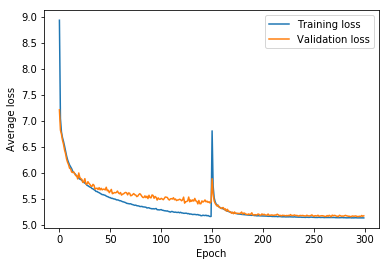

In [16]:
# Average loss per epoch
ltrain_epochs = []
for epoch_list in losses_train_epochs:
  epoch_avg = sum(epoch_list) / len(train_loader)
  ltrain_epochs.append(epoch_avg)

ltest_epochs = []
for epoch_list in losses_test_epochs:
  epoch_avg = sum(epoch_list) / len(test_loader)
  ltest_epochs.append(epoch_avg)

# Print epoch achieving minimum vali loss
min_value = min(ltest_epochs)
min_index = ltest_epochs.index(min_value)

print("The lowest loss:", round(min_value,3), "is found at epoch:", min_index, "\n")

# Plot the losses over time
plt.plot(ltrain_epochs, label="Training loss")
plt.plot(ltest_epochs, label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.legend()
plt.show()

#### See predictions

In [ ]:
import math
from statistics import mean
from sklearn.metrics import mean_squared_error

# # Make lists of predictions and actual fractions (reference)
nested_pred = best_pred # results from the epoch with the minimum loss is taken
nested_actual = best_actual

unnested_pred = []
for data in nested_pred:
  for batch in data:
    for timestep in batch:
      for target in range(len(timestep)):
        unnested_pred.append(timestep[target])

unnested_actual = []
for data in nested_actual:
  for batch in data:
    for timestep in batch:
      for target in range(len(timestep)):
        unnested_actual.append(timestep[target])

# These lists contain output for entire predictions 
# Now retain lists for each class
pred_class = {}
true_class = {}

# Initialize lists for each class in predictions
for i in range(len(targets)):
  pred_class[f'{targets[i]}'] = unnested_pred[i::len(targets)]

# Initialize lists for each class in reference data
for i in range(len(targets)):
  true_class[f'{targets[i]}'] = unnested_actual[i::len(targets)]

RMSEavg = 0
MAEavg = 0

# Plot the lists as graphs

# Loop through the data and plot the actual and predicted values
for i in range(len(targets)):
    # Get the data for the current class
    true = true_class[f'{targets[i]}']
    predicted = pred_class[f'{targets[i]}']

    # Define the x-axis data as a range of values from 0 to the length of the data
    x = range(len(true))

    # Create a new figure
    fig = plt.figure(i)

    # Create a figure with certain size
    fig = plt.figure(figsize=(20, 3))

    # Create axes
    ax = fig.add_subplot(1, 1, 1)

    # Plot the actual and predicted values
    ax.plot(x, true, label='Actual')
    ax.plot(x, predicted, label='Predicted')

    # Add a legend
    ax.legend()

    # Set the title using the class name
    var_name = f'{targets[i]}'
    ax.set_title(var_name)

    # Show the figure
    plt.show()

    # Print RMSE / MAE
    rmse = mean_squared_error(predicted, true) ** 0.5
    RMSEavg = RMSEavg + rmse
    print(f'RMSE for {var_name}: {round(rmse, 2)}')

    difference = [abs(predicted - true) for predicted, true in zip(predicted, true)]
    mae = mean(difference)
    MAEavg = MAEavg + mae
    print(f'MAE for {var_name}: {round(mae, 2)}')

print("\n")
RMSEavg = RMSEavg / len(targets)
MAEavg = MAEavg / len(targets)

print(f'Average RMSE is {round(RMSEavg, 2)} and average MAE is {round(MAEavg, 2)}')

### Join predictions with IDs and write to file

In [ ]:
validf = LSTM_vali.copy() # either LSTM_vali or RF_vali

# Add IDs (vali data was not shuffled so can add like this --- checked with excel!)
import pandas as pd
pred_df = validf.loc[:, ['sample_id', 'location_id', 'validation_id', 'reference_year', 'x', 'y']]

# Adds predictions to df 
for i in range(len(targets)):
  data = pred_class[f'{targets[i]}']
  pred_df[targets[i]] = data 

# Show df
pred_df.head(12)

In [20]:
pred_df.to_csv('Output/PostLSTM/LSTM_PostLSTM_pred.csv')